<a href="https://colab.research.google.com/github/Dichik/gathers-nlp-final-project/blob/main/src/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TOKENIZERS_PARALLELISM"]="true"
import calendar

import pandas as pd
import numpy as np 
import gensim
import nltk
import spacy
import re
import torch
import torch.nn as nn

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from copy import deepcopy
import json

%matplotlib inline

In [52]:
def read_file(path: str):
    f = open(path)
    data = json.load(f)
    
    date_info = []
    dataset = []
    for i in data:
        try:
            text = i.get('message')
            dt = i.get('date')
            dataset.append(text)
            date_info.append(dt)
        except:
              print('error')
    
    f.close()
    return pd.DataFrame({'Message': dataset, 'Date': date_info})

In [53]:
regular_news = read_file('regular_news.json')
poss_manipulations = read_file('poss_manipulations.json')

manipulatives = pd.read_csv('manipulatives.csv')
reals = pd.read_csv('reals.csv')
manipulatives['Date'] = None
reals['Date'] = None

In [54]:
regular_news.head()

,Message,Date
0,🤡 У санкт-петербурзі закрили аеропорт через не...,2023-02-28T10:02:45+00:00
1,🤡 Тепер збирають «на священну війну»\n\nШахраї...,2023-02-28T09:40:04+00:00
2,💥 Уночі росіяни обстріляли Святогірськ і влучи...,2023-02-28T09:16:00+00:00
3,,2023-02-28T08:55:02+00:00
4,Влада російської Адигеї заявила про падіння не...,2023-02-28T08:55:02+00:00


In [55]:
poss_manipulations.head()

,Message,Date
0,#ЦПД_аналізує досьє пропагандистки ю.барановсь...,2023-02-27T11:00:05+00:00
1,⏺#ЦПД_застерігає: ворожі медіа поширили «докум...,2023-02-27T09:30:18+00:00
2,⏺#ЦПД_виявляє: станом на ранок 27.02.2023 окуп...,2023-02-27T07:30:51+00:00
3,#ЦПД_розвінчує: Пропагандисти поширюють дезінф...,2023-02-26T19:31:23+00:00
4,,2023-02-26T17:00:38+00:00


In [56]:
poss_manipulations.dropna(inplace=True)

In [57]:
print(reals.isna().sum())
print('~~~~~~~')
print(regular_news.isna().sum())

Unnamed: 0      0
Message       346
Date          445
dtype: int64
~~~~~~~
Message    1
Date       0
dtype: int64


In [58]:
def preclean_text(df, type_text="manipulation"):
    if type_text == 'manipulation':
        manipulation = []
        for i, item in df.iterrows():
            if item[0] is None:
                continue
            for i in range(len(item[0].split('\n'))):
                text = item[0].split('\n')
                if 'Маніп' in text[i]:
                    if 'заявив, що' in text[i+1]:
                        text_split = text[i+1].split('заявив, що')
                        manipulation.append(text_split[1])
                    elif 'заявили, що' in text[i]:
                        text_split = text[i+1].split('заявили, що')
                        manipulation.append(text_split[1])
                    elif 'заявили:' in text[i+1]:
                        text_split = text[i+1].split('заявили:')
                        manipulation.append(text_split[1])
                    elif 'заявив:' in text[i+1]:
                        text_split = text[i+1].split('заявив:')
                        manipulation.append(text_split[1])
                    elif 'повідомив, що' in text[i+1]:
                        text_split = text[i+1].split('повідомив, що')
                        manipulation.append(text_split[1])
                    elif 'повідомили, що' in text[i+1]:
                        text_split = text[i+1].split('повідомили, що')
                        manipulation.append(text_split[1])
                    elif 'повідомив:' in text[i+1]:
                        text_split = text[i+1].split('повідомив:')
                        manipulation.append(text_split[1])
                    elif 'повідомили:' in text[i+1]: 
                        text_split = text[i+1].split('повідомили:')
                        manipulation.append(text_split[1])
                    else:
                        text_split = text[i+1]
                        manipulation.append(text_split)
        print(len(manipulation))
        return pd.DataFrame({'Message': list(set(manipulation))})
                    
    if type_text == 'normal':
        normal = []
        for i, item in df.iterrows():
            if item[0] is None:
                continue
            elif 'тривога' in item[0]:
                continue
            elif 'вибух' in item[0]:
                continue
            
            elif '——' in item[0]:
                    text_split = item[0].split('——')
                    normal.append(text_split[0])
            elif '____' in item[0]:
                    text_split = item[0].split('____')
                    normal.append(text_split[0])
            else:
                    text_split = item[0]
                    normal.append(text_split)
    
        return pd.DataFrame({'Message': list(set(normal))})

In [59]:
df_normal = preclean_text(poss_manipulations, type_text='manipulation')
df_manipulation = preclean_text(regular_news, type_text='normal')

503


In [60]:
df_manipulation.iloc[1].values[0]

'❗️Різниця військового потенціалу між Україною і росією з 24 лютого поступово скорочується\n\nЦЕНТР'

In [61]:
df_manipulation['Message'].astype(bool).sum()

4243

In [62]:
df_manipulation['Message'] = df_manipulation[df_manipulation['Message'].astype(bool)]

In [63]:
df_manipulation.dropna(inplace=True)

In [64]:
df_manipulation.reset_index(drop=True, inplace=True)

In [65]:
df_manipulation.head()

,Message
0,❗️Різниця військового потенціалу між Україною ...
1,🔥За добу ЗСУ ліквідували ще 420 російських оку...
2,🤬 Внаслідок чергового ракетного удару пошкодж...
3,"💡У Києві, Одесі та Дніпрі зранку діють екстрен..."
4,💔 Так нині в Україні проходять спортивні змага...


In [66]:
df_normal.head()

,Message
0,
1,"«українська влада порахувала, скільки грошей ..."
2,«В.Зеленський злякався російської мобілізації...
3,віце-канцлер Австрії Г.Штрахе на мітингу у Ві...
4,"«Американців більше турбують ціни на хліб, га..."


In [67]:
manipulation_news = poss_manipulations[poss_manipulations['Message'].str.contains('Маніпуляці')]
manipulation_news.tail()

,Message,Date
2715,#ЦПД_виявляє: станом на ранок 10.05 окупанти п...,2022-05-10T05:17:48+00:00
2716,#ЦПД_виявляє: протягом дня російські пропаганд...,2022-05-09T19:30:03+00:00
2724,#ЦПД_виявляє: станом на ранок 09.05.2022 року ...,2022-05-09T05:12:22+00:00
3024,"☝🏻ЦПД при РНБО України підтверджує, що путін м...",2022-04-12T14:48:35+00:00
4078,‼️Увага! Маніпуляція!\n\n⚫Російські пропаганди...,2022-02-24T09:50:12+00:00


In [68]:
manipulation_news = manipulation_news.append(manipulatives)[['Message']]
manipulation_news.reset_index(inplace=True)
manipulation_news.drop(columns=['index'], inplace=True)
manipulation_news['Message'] = manipulation_news['Message'].astype(str)
manipulation_news.tail()

,Message
1249,Кремль використовує своїх проксі в Україні для...
1250,nan
1251,Українські військові почали отримувати смс-пов...
1252,Такі повідомлення поширюють російські медіа з ...
1253,Велика Британія та Туреччина планують скупити ...


In [69]:
manipulation_news = manipulation_news[~(manipulation_news['Message'] == 'nan')]
manipulation_news.count()

Message    1249
dtype: int64

In [70]:
reals.reset_index(drop=True, inplace=True)
regular_news.reset_index(drop=True, inplace=True)

In [71]:
df_reals = pd.concat([reals, regular_news], axis=0, ignore_index=True)
df_reals = pd.DataFrame(df_reals, columns=['Message'], dtype=str)
df_reals.tail(5)

,Message
6440,
6441,
6442,"росія, ймовірно, готується до широкомасштабног..."
6443,Жодного дня на росії спокійного не буває😈\n\nЦ...
6444,🇵🇱 Польський Сейм визнав росію державою-спонсо...


In [72]:
df_reals = df_reals[~(df_reals['Message'] == 'nan')]
df_reals.count()

Message    6099
dtype: int64

In [73]:
df_reals['is_manipulation'] = 0
manipulation_news['is_manipulation'] = 1

<ipython-input-73-1e322b566fe4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manipulation_news['is_manipulation'] = 1


In [74]:
dataset = pd.concat([df_reals, manipulation_news])

df = pd.DataFrame(dataset, columns=['Message', 'is_manipulation'])
df.reset_index(drop=True, inplace=True)
df.head()

,Message,is_manipulation
0,У Сеймі справді виконували гімн України на зна...,0
1,"Італійський рис справді потрапив до України, о...",0
2,Твердження про зашифровані символи у кількості...,0
3,На неї звернули увагу аналітики проєкту VoxChe...,0
4,На неї звернули увагу аналітики проєкту The In...,0


In [75]:
df.isna().sum()

Message            0
is_manipulation    0
dtype: int64

In [76]:
df['Message'] = df['Message'].astype(str)
df.head()

,Message,is_manipulation
0,У Сеймі справді виконували гімн України на зна...,0
1,"Італійський рис справді потрапив до України, о...",0
2,Твердження про зашифровані символи у кількості...,0
3,На неї звернули увагу аналітики проєкту VoxChe...,0
4,На неї звернули увагу аналітики проєкту The In...,0


In [77]:
df['is_manipulation'].value_counts()

0    6099
1    1249
Name: is_manipulation, dtype: int64

In [78]:
f = open('stop_words.txt')

stop_words = []
for word in f:
  stop_words.append(word)

stop_words.extend(['re', 'edu', 'inst', 'https', 'також'])
len(stop_words)

1988

In [79]:
!pip install uk-stemmer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement uk-stemmer (from versions: none)
ERROR: No matching distribution found for uk-stemmer


In [80]:
nltk.download('punkt')
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# stemming / lemmatization? - we have Україна, України, etc. in wordcloud

def process_row(input, join_back=True):

    if isinstance(input, str):
        tokens = tokenizer.tokenize(input)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 3 and not w.startswith("цпд_")]
        if len(filtered_words) > 0 and filtered_words[-1] == 'центр':
          filtered_words = filtered_words[:len(filtered_words) - 1]

        input = " ".join(filtered_words)
        input = re.sub(r"http\S+", "", input)
        input = re.sub(r"\n+", ". ", input)
        for symb in ["!", ",", ":", ";", "?"]:
            input = re.sub(rf"\{symb}\.", symb, input)
        input = re.sub("[^а-яА-Яa-zA-Z0-9!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}]+", " ", input)
        input = re.sub(r"#\S+", "", input)

        for symb in ["!", ",", ":", ";", "?"]:
            input = re.sub(rf"\{symb}\.", symb, input)
        
        input = input.strip()
        input = input.lower()
    return input


# import nltk
# from nltk.corpus import stopwords
# from nltk.stem.snowball import SnowballStemmer
# from nltk.tokenize import word_tokenize
# nltk.download('stopwords')
# nltk.download('punkt')

# def process_row(text):
#     # Lowercase
#     text = text.lower()
#     # Remove punctuation
#     text = "".join(c for c in text if c not in ('!','.',',',':',';','-','–',')','('))
#     # Tokenize
#     tokens = word_tokenize(text)
#     tokens = [t for t in tokens if t not in stop_words]
#     # Stemming
#     # stemmer = SnowballStemmer('ukrainian')
#     stemmed_tokens = [stemmer.stem(t) for t in tokens]
#     # Join the tokens back into a single string
#     text = " ".join(stemmed_tokens)
#     return text

df['cleaned_text'] = df['Message'].apply(lambda x: process_row(str(x)))
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Message,is_manipulation,cleaned_text
0,У Сеймі справді виконували гімн України на зна...,0,сейм справд виконували г мн укра ни знак сол д...
1,"Італійський рис справді потрапив до України, о...",0,тал йський справд потрапив укра ни однак того ...
2,Твердження про зашифровані символи у кількості...,0,твердження зашифрован символи к лькост танк в ...
3,На неї звернули увагу аналітики проєкту VoxChe...,0,звернули увагу анал тики про кту voxcheck вони...
4,На неї звернули увагу аналітики проєкту The In...,0,звернули увагу анал тики про кту insider вони ...


In [81]:
df.dropna(inplace=True)
df.head()

,Message,is_manipulation,cleaned_text
0,У Сеймі справді виконували гімн України на зна...,0,сейм справд виконували г мн укра ни знак сол д...
1,"Італійський рис справді потрапив до України, о...",0,тал йський справд потрапив укра ни однак того ...
2,Твердження про зашифровані символи у кількості...,0,твердження зашифрован символи к лькост танк в ...
3,На неї звернули увагу аналітики проєкту VoxChe...,0,звернули увагу анал тики про кту voxcheck вони...
4,На неї звернули увагу аналітики проєкту The In...,0,звернули увагу анал тики про кту insider вони ...


In [82]:
df = df[df['Message'].apply(len) > 3]
df.head()

,Message,is_manipulation,cleaned_text
0,У Сеймі справді виконували гімн України на зна...,0,сейм справд виконували г мн укра ни знак сол д...
1,"Італійський рис справді потрапив до України, о...",0,тал йський справд потрапив укра ни однак того ...
2,Твердження про зашифровані символи у кількості...,0,твердження зашифрован символи к лькост танк в ...
3,На неї звернули увагу аналітики проєкту VoxChe...,0,звернули увагу анал тики про кту voxcheck вони...
4,На неї звернули увагу аналітики проєкту The In...,0,звернули увагу анал тики про кту insider вони ...


In [83]:
X = df['cleaned_text']
y = df['is_manipulation']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

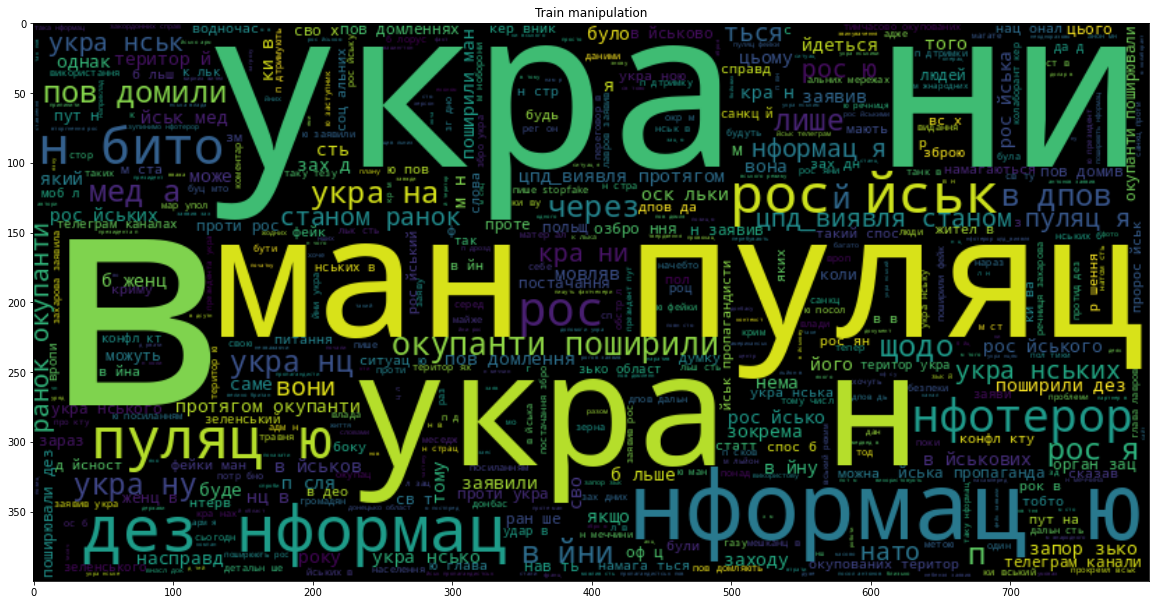

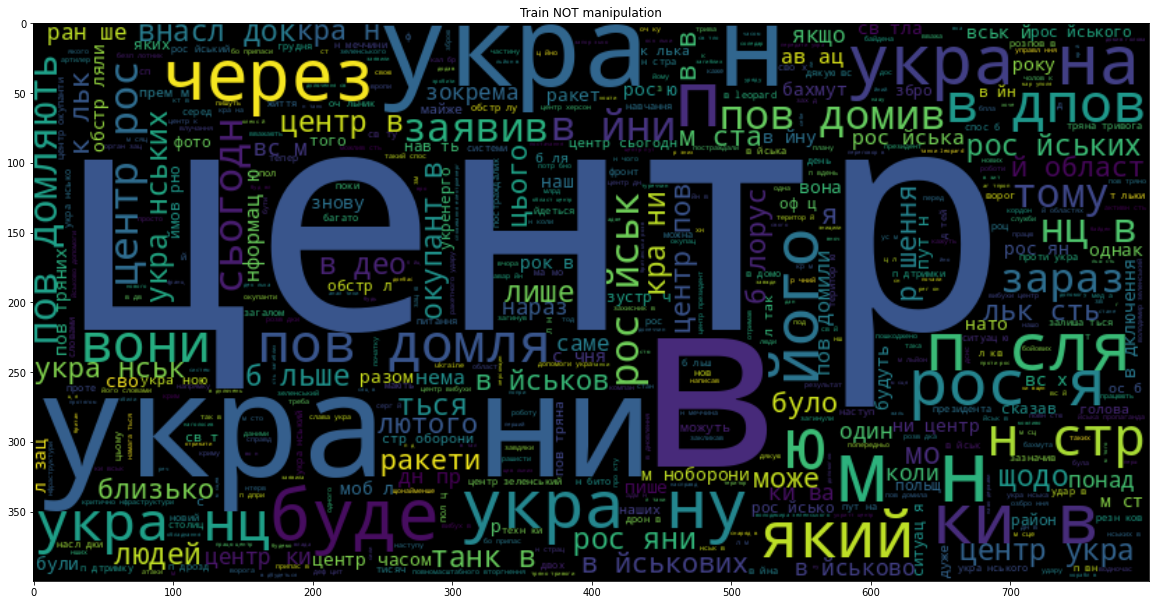

In [84]:
plt.figure(figsize = (20,20)) 
plt.title("Train manipulation")
wc = WordCloud(max_words = 500 , width = 800 , height = 400 , stopwords = stop_words).generate(" ".join(df.loc[df["is_manipulation"] == 1, 'cleaned_text']))
plt.imshow(wc, interpolation = 'bilinear')

plt.figure(figsize = (20,20)) 
plt.title("Train NOT manipulation")
wc = WordCloud(max_words = 500 , width = 800 , height = 400 , stopwords = stop_words).generate(" ".join(df.loc[df["is_manipulation"] == 0, 'cleaned_text']))
plt.imshow(wc, interpolation = 'bilinear')

In [85]:
def comp_metric(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    class_roc_aucs = roc_auc_score(y_true, y_pred)
    print(f"Result Roc Auc: {class_roc_aucs}")
    return class_roc_aucs, np.mean(class_roc_aucs)

In [87]:
df.loc[df["cleaned_text"].str.contains('0365')]

,Message,is_manipulation,cleaned_text
3982,❤️ Різдвяний збір на 10 автівок для бійців ЗСУ...,0,р здвяний зб р авт вок б йц в в дкрива мо зб р...


## Clustering

In [86]:
# TODO maybe we can find smth interesting

## TF-IDF

In [88]:
tf_idf_object = TfidfVectorizer()
tf_idf_matrix = tf_idf_object.fit_transform(
    df["cleaned_text"].iloc[:6005]
)
print(tf_idf_object.get_feature_names_out().tolist())
print(f"Bag of Words: {tf_idf_object.get_feature_names_out()}")

['0010', '0246', '0323', '0365', '0485', '0698', '1000', '100500', '1010', '1030', '1034', '1040', '1042', '10rc', '1100', '1140', '1144', '11ec', '1200', '1208', '125мм', '1278', '1288', '1300', '1351', '1397', '1400', '1404', '1470', '1498', '1500', '15000', '1550', '15min', '15серпня', '1650', '1700', '1750', '1782', '1800', '1833', '1863', '1873', '1894', '1899', '1917', '1918', '1919', '1921', '1930', '1932', '1933', '1938', '1939', '1941', '1942', '1943', '1943р', '1944', '1945', '1960', '1970', '1973', '1980', '1982', '1983', '1988', '1990', '1991', '1992', '1994', '1998', '1999', '19fortyfive', '1серпня', '2000', '2001', '2005', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2014р', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2030', '2032', '2034', '2035', '2080', '2100', '212a', '22м3', '2300', '2357', '2500', '2700', '2776', '2992', '2fkubceskd', '2pauhx1agl', '2с19', '3000', '300пу', '31пд', '334t

In [89]:
list_drop = []
for i, el in enumerate(tf_idf_object.get_feature_names_out().tolist()):
    if el == 'аарон':
        for ell in tf_idf_object.get_feature_names_out().tolist()[:i]:
            list_drop.append(ell)

In [90]:
index_drop = []
for it in list_drop:
    # print(it)
    # print('-'*80)
    for i, item in df.iterrows():
        # print(item[0])
        if it in item[0]:
            # print(it)
            # print(item[0])
    # df["cleaned_text"].str.contains(it))
            index_drop.append(df.loc[df['Message'] == item[0]].index.values[0])
# df.head()

In [91]:
df.drop(index_drop, inplace=True)

In [92]:
df.head()

,Message,is_manipulation,cleaned_text
1,"Італійський рис справді потрапив до України, о...",0,тал йський справд потрапив укра ни однак того ...
2,Твердження про зашифровані символи у кількості...,0,твердження зашифрован символи к лькост танк в ...
3,На неї звернули увагу аналітики проєкту VoxChe...,0,звернули увагу анал тики про кту voxcheck вони...
6,"Немає жодних доказів, що повістку вручили саме...",0,нема жодних доказ в пов стку вручили саме чино...
7,"За результатами дослідження групи «Рейтинг», н...",0,результатами досл дження групи рейтинг сьогодн...


In [93]:
df.loc[df['Message'] == item[0]].index.values[0]

7347

In [94]:
df.loc[df["cleaned_text"].str.contains('3wkfgmpbdzc')]

,Message,is_manipulation,cleaned_text


In [95]:
tf_idf_object = TfidfVectorizer()
tf_idf_matrix = tf_idf_object.fit_transform(
    df["cleaned_text"].iloc[:6005]
)
print(tf_idf_object.get_feature_names_out().tolist())
print(f"Bag of Words: {tf_idf_object.get_feature_names_out()}")
# print(
#     f"Text : {df['cleaned_text'].iloc[1]}\n"
#     f"Vectorization: {tf_idf_object.transform([df['cleaned_text'].iloc[1]]).toarray()[0]}"
# )

['10rc', '2005', '2007', '2021', '2022', '2023', '212a', '22м3', '2с19', '3воф45', '4service', 'a3gn', 'abrams', 'accent', 'achmatowisch', 'affairs', 'agoravox', 'airbaltic', 'airbus', 'akeron', 'akhmadovitch', 'alert', 'alina', 'altius', 'american', 'ansa', 'antena', 'anzeiger', 'arabia', 'arabiya', 'archer', 'as90', 'aspide', 'associated', 'aster', 'atacms', 'atlas', 'attack', 'australia', 'australian', 'autonomy', 'avenger', 'axios', 'balss', 'baltijas', 'bandvagn', 'basset', 'bastion', 'baykar', 'bayraktar', 'baza', 'belga', 'berlingske', 'bfmtv', 'bild', 'binance', 'black', 'bloomberg', 'boeing', 'bofors', 'boston', 'boxer', 'bradley', 'broomberg', 'bypol', 'bytedance', 'caesar', 'camp', 'carl', 'cbos', 'ceasar', 'central', 'challenger', 'chatgpt', 'check', 'chef', 'china', 'cirium', 'citroen', 'class', 'coins', 'combat', 'conservative', 'consult', 'cope', 'copernicus', 'covid', 'credit', 'crimes', 'cristal', 'csis', 'cyberlux', 'cам', 'cанкц', 'cенат', 'cитуац', 'cолнцепьок', 'da

## Logistic Regression

In [96]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
folds_train_test_ids = [el for el in skf.split(X_train, y_train)]
# FIXME add k-fold

In [97]:
model = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("lof_reg", LogisticRegression())
])

all_train_pred = model.fit(
    X_train, 
    y_train
).predict_proba(X_train)

all_train_pred = np.stack([el[1] for el in all_train_pred])

comp_metric(y_train.values, all_train_pred)

Result Roc Auc: 0.9999984542156052


(0.9999984542156052, 0.9999984542156052)

In [98]:

all_train_preds = []
all_test_preds = []
all_train_targets = []
all_test_targets = []
all_models = []
for fold_id, (train_ids, test_ids) in enumerate(folds_train_test_ids):
    parameters = {
        'model__C': [.01, .1, 1, 10],
        'model__penalty': ['l1', 'l2']
    }
    pipeline = Pipeline([
        ("vectorizer", TfidfVectorizer()),
        ("model", LogisticRegression())
    ])
    # print(LogisticRegression().get_params().keys())
    grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=parameters)
    grid.fit(X_train.iloc[train_ids], y_train.iloc[train_ids])
    fold_train_preds = grid.predict_proba(X_train.iloc[train_ids])
    fold_train_preds = np.stack([el[1] for el in fold_train_preds])
    fold_test_preds = grid.predict_proba(X_train.iloc[test_ids])
    fold_test_preds = np.stack([el[1] for el in fold_test_preds])
    fold_train_targets = y_train.iloc[train_ids].values
    fold_test_targets = y_train.iloc[test_ids].values
    print(f"Fold {fold_id}")
    print("Train: ")
    comp_metric(fold_train_targets, fold_train_preds);
    print("Test: ")
    comp_metric(fold_test_targets, fold_test_preds);
    all_train_preds.append(fold_train_preds)
    all_test_preds.append(fold_test_preds)
    all_train_targets.append(fold_train_targets)
    all_test_targets.append(fold_test_targets)
    all_models.append(grid)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

Fold 0
Train: 
Result Roc Auc: 1.0
Test: 
Result Roc Auc: 0.9872685630701721


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

Fold 1
Train: 
Result Roc Auc: 1.0
Test: 
Result Roc Auc: 0.9873075805983154


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

Fold 2
Train: 
Result Roc Auc: 1.0
Test: 
Result Roc Auc: 0.9904153354632588


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

Fold 3
Train: 
Result Roc Auc: 0.9999999999999999
Test: 
Result Roc Auc: 0.9907445057604801


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

Fold 4
Train: 
Result Roc Auc: 0.9999999999999999
Test: 
Result Roc Auc: 0.9888289156626505


## RNN

In [99]:
class RNN(nn.Module):
    
    def __init__(
        self,
        num_embeddings,
        rnn_channels = 256,
        hidden_size = 512,
        rnn_type=nn.GRU,
    ):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings, rnn_channels) 
        self.rnns = rnn_type(
            rnn_channels, 
            hidden_size, 
            batch_first=True,
            num_layers=1,
        )
        self.hidden_size = hidden_size
        self.classifier = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        x = self.embedding_layer(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        x, _ = self.rnns(x, h0)
        x =  x.mean(1)
        # x = x[:, -1, :]
        x = self.classifier(x)
        return x
        
        

In [100]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        texts,
        targets,
        dataset_vocab,
        dataset_tokenizer,
        max_length,
        trim_policy="first"
    ):
        self.targets = targets
        self.texts = texts
        self.vocab = dataset_vocab
        self.tokenizer = dataset_tokenizer
        
        self.max_length = max_length
        if trim_policy not in ["random", "first"]:
            raise ValueError(f"{trim_policy} is not valid trim_policy")
        self.trim_policy = trim_policy
        
    def select_text_subsequance(self, input):
        if len(input) < self.max_length:
            return input + [0] * (self.max_length - len(input))
        elif len(input) > self.max_length:
            if self.trim_policy == "random":
                start = np.random.randint(0, len(input) - self.max_length)
            elif self.trim_policy == "first":
                start = 0
            return input[start : start + self.max_length]
        else: 
            return input
        
    def __getitem__(self, idx):
        text_ids = self.vocab(self.tokenizer(self.texts[idx]))
        text_ids = self.select_text_subsequance(text_ids)
        return (
            torch.LongTensor(text_ids), 
            self.targets[idx]
        )
    
    def __len__(self):
        return len(self.texts)

In [101]:
!python -m spacy download ru_core_news_sm

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-06 09:27:04.996095: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-06 09:27:04.996254: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-06 09:27:04.996290: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

In [102]:
tokenizer = get_tokenizer('spacy', language='ru_core_news_sm')

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(
    yield_tokens(X_train), 
    specials=["<unk>"]
)
vocab.set_default_index(vocab["<unk>"])

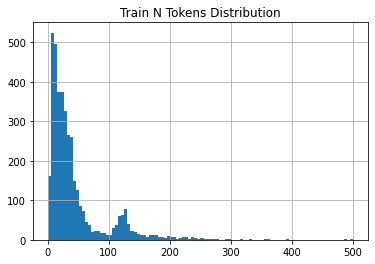

0.5 Quantile of N tokens: 26.0


In [103]:
train_n_tokens = X_train.apply(lambda x : len(tokenizer(x)))

plt.title("Train N Tokens Distribution")
train_n_tokens.hist(bins=100)
plt.show()

print(f"0.5 Quantile of N tokens: {np.quantile(train_n_tokens, 0.50)}")


In [104]:
train_torch_dataset = TextDataset(
    texts=X_train.iloc[folds_train_test_ids[0][0]].to_list(),
    targets=y_train.iloc[folds_train_test_ids[0][0]].to_list(),
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=50,
)

train_torch_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset,
    batch_size=16,
    shuffle=False,
    drop_last=True,
    pin_memory=True
)

valid_torch_dataset = TextDataset(
    texts=X_train.iloc[folds_train_test_ids[0][1]].to_list(),
    targets=y_train.iloc[folds_train_test_ids[0][1]].to_list(),
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=50,
)

valid_torch_dataloader = torch.utils.data.DataLoader(
    valid_torch_dataset,
    batch_size=16,
    shuffle=False,
    drop_last=True,
    pin_memory=True
)

test_torch_dataset = TextDataset(
    texts=X_test.to_list(),
    targets=y_test.to_list(),
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=50,
)

test_torch_dataloader = torch.utils.data.DataLoader(
    test_torch_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    pin_memory=True
)

In [105]:

def torch_loop(
    dataloader, 
    inp_model,
    inp_optimizer,
    inp_criterion,
    mode="train",
    device="cpu"
):
    if mode == "train":
        inp_model.train()
    else:
        inp_model.eval()
    all_predicted_label = []
    all_losses = []
    all_targets = []
    with torch.inference_mode(mode=(mode != "train")):
        for text, label in tqdm(dataloader):
            if mode == "train":
                inp_optimizer.zero_grad()
            predicted_label = inp_model(text)
            predicted_label = torch.squeeze(torch.sigmoid(predicted_label))
            loss = criterion(predicted_label, label.float())
            if mode == "train":
                loss.mean().backward()
                optimizer.step()
                
            all_predicted_label.append(predicted_label.detach().numpy())
            all_losses.append(loss.item())
            all_targets.append(label.detach().numpy().astype(np.float32))

    all_predicted_label = np.concatenate(all_predicted_label, axis = 0)
    all_losses = np.array(all_losses)
    all_targets = np.concatenate(all_targets, axis = 0)

    return all_predicted_label, all_losses, all_targets

In [106]:
nn_model = RNN(
    num_embeddings=len(vocab),
 )

criterion = nn.BCELoss()
# TODO: Try to tune hyperparameters here
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.5, min_lr=1e-7, mode="max", verbose=True)

In [107]:
n_epochs = 5

train_all_epoch_labels = []
train_all_epoch_losses = []
train_all_epoch_targets = []
valid_all_epoch_labels = []
valid_all_epoch_losses = []
valid_all_epoch_targets = []
valid_roc_aucs = []
train_roc_aucs = []

best_metric = - np.inf
best_model_state_dict = None

for epoch in range(1, n_epochs + 1):
    print(f"Starting Epoch {epoch}")
    # 1.1 Iterate over all train dataset and update model weights
    print("Train phase")
    train_epoch_labels, train_epoch_losses, train_epoch_targets = torch_loop(
        dataloader=train_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device="cuda",
        mode="train"
    )
    # 1.2 Compute and print train metrics
    train_roc_auc = roc_auc_score(
        train_epoch_targets, 
        train_epoch_labels
    )
    print("roc_aur", train_roc_auc)
    # 2.1 Iterate over all valid dataset and compute predictions
    print("Valid phase")
    valid_epoch_labels, valid_epoch_losses, valid_epoch_targets = torch_loop(
        dataloader=valid_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device="cuda",
        mode="eval"
    )
    # 2.2 Compute and print valid metrics
    valid_roc_auc = roc_auc_score(
        valid_epoch_targets, 
        valid_epoch_labels
    )
    print("roc_aur", valid_roc_auc)

    # 3. Update learning rate (if needed)
    scheduler.step(valid_roc_auc)
    # 4. Save best model
    if valid_roc_auc > best_metric:
        best_metric = valid_roc_auc
        best_model_state_dict = deepcopy(nn_model.state_dict())
    # 5. Accumulate all stats  
    train_all_epoch_labels.append(train_epoch_labels)
    train_all_epoch_losses.append(train_epoch_losses)
    train_all_epoch_targets.append(train_epoch_targets)
    valid_all_epoch_labels.append(valid_epoch_labels)
    valid_all_epoch_losses.append(valid_epoch_losses)
    valid_all_epoch_targets.append(valid_epoch_targets)
    valid_roc_aucs.append(valid_roc_auc)
    train_roc_aucs.append(train_roc_auc)

Starting Epoch 1
Train phase


100%|██████████| 197/197 [01:17<00:00,  2.53it/s]


roc_aur 0.9741900968184722
Valid phase


100%|██████████| 49/49 [00:04<00:00, 11.69it/s]


roc_aur 0.9980309587866029
Starting Epoch 2
Train phase


100%|██████████| 197/197 [00:59<00:00,  3.33it/s]


roc_aur 0.9986395888807026
Valid phase


100%|██████████| 49/49 [00:02<00:00, 17.27it/s]


roc_aur 0.9976507973642141
Starting Epoch 3
Train phase


100%|██████████| 197/197 [00:57<00:00,  3.45it/s]


roc_aur 0.9995585542345471
Valid phase


100%|██████████| 49/49 [00:02<00:00, 18.04it/s]


roc_aur 0.9978652473973565
Epoch 00003: reducing learning rate of group 0 to 5.0000e-04.
Starting Epoch 4
Train phase


100%|██████████| 197/197 [00:56<00:00,  3.48it/s]


roc_aur 1.0
Valid phase


100%|██████████| 49/49 [00:02<00:00, 18.09it/s]


roc_aur 0.9982259133621866
Starting Epoch 5
Train phase


100%|██████████| 197/197 [00:57<00:00,  3.42it/s]


roc_aur 1.0
Valid phase


100%|██████████| 49/49 [00:02<00:00, 18.17it/s]

roc_aur 0.9980602019729402


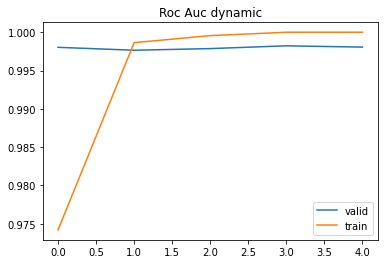

In [108]:
plt.title("Roc Auc dynamic")
plt.plot(valid_roc_aucs, label="valid")
plt.plot(train_roc_aucs, label="train")
plt.legend()
plt.show()

In [109]:
nn_model.load_state_dict(best_model_state_dict)

test_labels, test_losses, test_targets = torch_loop(
    dataloader=test_torch_dataloader, 
    inp_model=nn_model,
    inp_optimizer=optimizer,
    inp_criterion=criterion,
    mode="eval"
)

print("Test metrics")
print(roc_auc_score(
    test_targets, 
    test_labels
))

100%|██████████| 61/61 [00:07<00:00,  8.06it/s]

Test metrics
0.9966790503946342


## References

- https://github.com/skupriienko/Ukrainian-Stopwords